In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.cluster.hierarchy import linkage, cophenet, fcluster, dendrogram
# from tensorflow.examples.tutorials.mnist import input_data
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from sklearn.manifold import TSNE
import os

fontsize = 16
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
legend_size =14
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

font = {'family': 'normal',
        'weight': 'bold',
        'size': 24}

plt.rc('font', **font)
params = {'legend.fontsize': 'x-large',
          # 'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
sns.set()


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

np.random.seed(31415)
seed=31415

## Load Data

In [2]:
dataset = 'mds'

if dataset == 'seer':
    time = 'months'    
else:  
    time = 'days'

# data_path = 'analysis/{}/'.format(dataset)
data_path = 'matrix/'.format(dataset)
empirical = np.load(data_path + "Test_empirical_t.npy")
event  = np.load(data_path + "Test_empirical_e.npy")
print("data_path: ", data_path)
print("event: ", event.shape)
print("empirical: ", empirical.shape)
assert(len(event) == len(empirical))

data_path:  matrix/
event:  (233,)
empirical:  (233,)


In [3]:
# load observed & censored
gamma = 3
model = 'sca/gamma_{}/'.format(gamma)
# sca = np.load(data_path + '{}Test_predicted_t_samples.npy'.format(model))
sca = np.load(data_path + 'Test_predicted_t_samples.npy')
print (sca.shape)

(200, 233)


In [4]:
# # centroids
# centroids = np.load(data_path + model + "Test_centroids.npy")
# pop_pi = np.load(data_path + model + "Test_pop_nk.npy")
centroids = np.load(data_path + "Test_centroids.npy")
pop_pi = np.load(data_path + "Test_pop_nk.npy")
print("centroids: ", centroids.shape)
print("pop_pi: ", pop_pi.shape)


centroids:  (8, 50)
pop_pi:  (8,)


In [5]:
predicted_samples_sca = np.transpose(sca)
print("predicted_samples_sca: ", predicted_samples_sca.shape)

predicted_samples_sca:  (233, 200)


# Assign to Centroids

In [6]:
def t_dist_distance(a, b):
    expanded_vectors = tf.expand_dims(a, 0)
    expanded_centroids = tf.expand_dims(b, 1)
    distances = 1 + tf.reduce_sum(tf.square(
        tf.subtract(expanded_vectors, expanded_centroids)), 2)

    return distances

def compute_prob(dist):
    p_dist = 1.0 / dist
    p_dist = p_dist / tf.reduce_sum(p_dist, axis=1, keepdims=True)

    p_target = p_dist * pop_pi
    p_target = p_target / tf.reduce_sum(p_target, axis=1, keepdims=True)

    return p_target

def cluster_assignment(centroids, embed_z):
    distance = tf.transpose(t_dist_distance(a=embed_z, b=centroids))
    p_target = compute_prob(dist=distance)
    
    nearest_indices = tf.argmax(p_target, axis=1)
    return nearest_indices, p_target

# Plot Cluster-based KM

In [7]:
def kaplan_meir_with_clusters(clusters, name, num_clusters, test_e, test_empirical, colors):
    print("test_empirical:{}, test_e:{}".format(test_empirical.shape, test_e.shape))
    
    fig = plt.figure(figsize=(5, 4))
    clustered_stats = []
    ax = fig.add_subplot(111)
    kmf = KaplanMeierFitter()
    handles = []
    for i, c in enumerate(np.unique(clusters)):
        idx_c = clusters == c
        cluster_t = test_empirical[idx_c]
        cluster_e = test_e[idx_c]
        handles.append(mpatches.Patch(color=colors[c], label="{} ({})".format(c, len(cluster_t))))
        observed = cluster_e == 1
        observed_t = cluster_t[observed]
        kmf.fit(cluster_t, event_observed=observed, label=c)
        kmf.survival_function_.plot(ax=ax, color=colors[c], lw=2)
        cluster_dic = {'Cluster': c, '% Observed': len(observed_t) / len(cluster_t), 'Size': len(cluster_t),
                       'mean(observed time)': np.mean(observed_t), 'std(observed time)': np.std(observed_t)}
        clustered_stats.append(cluster_dic)
    handles.append(mpatches.Patch(color='black', label='average ({})'.format(len(test_empirical))))
    kmf.fit(test_empirical, event_observed=test_e, label='average ({})'.format(len(test_empirical)))
    kmf.survival_function_.plot(ax=ax, color='black', lw=2)
    plt.tick_params(axis='both', which='major', labelsize=legend_size)
    plt.legend(handles=handles, fontsize=legend_size, bbox_to_anchor=(0.9,0.6))
    plt.ylabel("Probability of survival", fontsize=BIGGER_SIZE)
    plt.xlabel("Time ({})".format(time), fontsize=BIGGER_SIZE)
    print("clustered_stats:{}".format(clustered_stats))
    #fig.savefig(dataset+str(num_clusters)+'_learning_curve.pdf', bbox_inches='tight')
    
def plot_kaplan_meier_curves(name,clusters, test_empirical, test_e, colors):
    num_clusters = len(np.unique(clusters))
    kaplan_meir_with_clusters(clusters, name, num_clusters, test_e, test_empirical, colors=colors)

# Cluster assignments

In [8]:
# z = np.load (data_path + model + 'Test_z.npy')
z = np.load (data_path + 'Test_z.npy')
test_z_centroids = np.concatenate((z, centroids), axis=0)

# fname = data_path + model + 'tsne_test_z_centroids.npy'
fname = data_path + 'tsne_test_z_centroids.npy'
print (fname)
if os.path.isfile(fname):
    print ('Loading file...')
    tsne_test_z_centroids = np.load(fname)
else:
    perp=50
    tsne = TSNE(random_state=seed, perplexity=perp, verbose=1, n_components=2, init='pca', n_iter=5000)
    tsne_test_z_centroids = tsne.fit_transform(test_z_centroids)
    np.save(fname, tsne_test_z_centroids)   


matrix/tsne_test_z_centroids.npy
Loading file...


In [9]:
# manfred
tf.compat.v1.disable_eager_execution()
nn_model, p_target =tf.compat.v1.Session().run(cluster_assignment(embed_z=z, centroids=centroids))
    
assigned_c = {}
for value, key in enumerate(np.unique(nn_model)):
    assigned_c[key] = value 

print("unique_assignments: ", assigned_c, "size: ", len(assigned_c))

print(list(assigned_c.keys()))

keys = np.unique(nn_model)

unique_assignments:  {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6} size:  7
[0, 1, 2, 3, 5, 6, 7]


In [10]:
clusters = np.copy(nn_model)
for k in range(len(nn_model)):
    for i, c in enumerate(assigned_c.keys()):
        if (nn_model[k] == c):
            clusters[k] = i
print(nn_model)
print(clusters)
np.savetxt('./clusters.txt', clusters, delimiter=',')

[5 5 7 2 6 0 6 6 6 6 6 3 5 5 7 6 6 6 6 5 3 6 2 5 6 6 6 2 3 5 7 6 3 5 7 6 5
 3 3 7 6 6 6 2 7 7 7 5 7 6 6 6 5 7 2 6 7 7 6 6 6 5 6 2 7 6 6 6 3 5 6 5 6 2
 7 3 6 6 3 3 6 7 3 6 6 2 6 5 7 6 0 3 6 6 3 6 5 2 6 6 3 2 2 3 6 3 7 5 7 6 5
 5 2 7 6 0 3 2 5 7 6 6 3 6 6 2 5 6 7 6 6 7 7 6 7 0 7 7 1 2 6 6 3 6 2 7 6 2
 5 6 3 1 7 6 2 6 7 3 6 5 5 3 0 6 3 2 2 6 5 5 5 5 5 5 5 6 7 7 6 6 3 6 7 7 3
 6 7 6 7 5 6 5 7 2 7 5 5 6 6 6 6 6 5 5 6 6 1 6 7 2 1 7 7 6 5 5 5 5 6 6 2 3
 3 6 7 3 3 6 6 6 6 6 6]
[4 4 6 2 5 0 5 5 5 5 5 3 4 4 6 5 5 5 5 4 3 5 2 4 5 5 5 2 3 4 6 5 3 4 6 5 4
 3 3 6 5 5 5 2 6 6 6 4 6 5 5 5 4 6 2 5 6 6 5 5 5 4 5 2 6 5 5 5 3 4 5 4 5 2
 6 3 5 5 3 3 5 6 3 5 5 2 5 4 6 5 0 3 5 5 3 5 4 2 5 5 3 2 2 3 5 3 6 4 6 5 4
 4 2 6 5 0 3 2 4 6 5 5 3 5 5 2 4 5 6 5 5 6 6 5 6 0 6 6 1 2 5 5 3 5 2 6 5 2
 4 5 3 1 6 5 2 5 6 3 5 4 4 3 0 5 3 2 2 5 4 4 4 4 4 4 4 5 6 6 5 5 3 5 6 6 3
 5 6 5 6 4 5 4 6 2 6 4 4 5 5 5 5 5 4 4 5 5 1 5 6 2 1 6 6 5 4 4 4 4 5 5 2 3
 3 5 6 3 3 5 5 5 5 5 5]


# Visualize Clusters

all_centroids:  (8, 2)
keys:  [0 1 2 3 5 6 7]


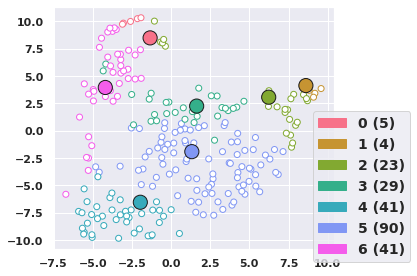

In [11]:
fig=plt.figure(figsize=(5,4))
size = len(z)
model_colors = sns.color_palette("husl", len(assigned_c))

plt.scatter(tsne_test_z_centroids[0:size, 0], tsne_test_z_centroids[0:size, 1], 
            edgecolors=[model_colors[assigned_c[i]] for i in nn_model],
            cmap='prism', c="w",  marker="o", label='Z')  

all_centroids = tsne_test_z_centroids[size:size+len(centroids)]
print("all_centroids: ", all_centroids.shape)
print("keys: ", keys)

plt.scatter(all_centroids[keys, 0], all_centroids[keys, 1], edgecolors='k',
            cmap='prism', c=[model_colors[assigned_c[i]] for i in keys], s=200,
            marker="o", label='Centroids')


handles = []
for i, c in enumerate(assigned_c.keys()):
    idx_c = nn_model == c
    cluster_t = nn_model[idx_c]
    handles.append(mpatches.Patch(color=model_colors[i], label="{} ({})".format(i, len(cluster_t))))
    #handles.append(mpatches.Patch(color=model_colors[i], label="{}".format(i)))

plt.tight_layout()
plt.legend(handles=handles, fontsize=legend_size, bbox_to_anchor=(0.9,0.6))
#fig.savefig(dataset+'_cluster_scatter.pdf', bbox_inches='tight')

test_empirical:(233,), test_e:(233,)


/home/manfred/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/manfred/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


clustered_stats:[{'Cluster': 0, '% Observed': 0.4, 'Size': 5, 'mean(observed time)': 864.0, 'std(observed time)': 382.0}, {'Cluster': 1, '% Observed': 0.0, 'Size': 4, 'mean(observed time)': nan, 'std(observed time)': nan}, {'Cluster': 2, '% Observed': 0.13043478260869565, 'Size': 23, 'mean(observed time)': 1284.0, 'std(observed time)': 751.2660425353102}, {'Cluster': 3, '% Observed': 0.41379310344827586, 'Size': 29, 'mean(observed time)': 1277.5, 'std(observed time)': 1055.2916263605368}, {'Cluster': 4, '% Observed': 0.5121951219512195, 'Size': 41, 'mean(observed time)': 888.6190476190476, 'std(observed time)': 559.3078610628604}, {'Cluster': 5, '% Observed': 0.2777777777777778, 'Size': 90, 'mean(observed time)': 1129.12, 'std(observed time)': 981.8846498443694}, {'Cluster': 6, '% Observed': 0.5121951219512195, 'Size': 41, 'mean(observed time)': 664.952380952381, 'std(observed time)': 877.6857272552998}]


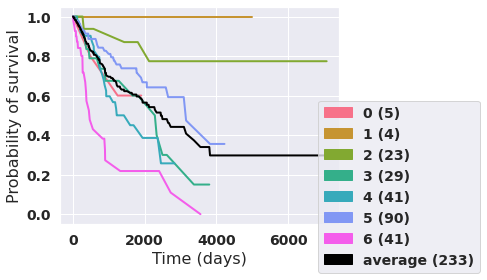

In [12]:
clust_unique = [assigned_c[i] for i in nn_model]
plot_kaplan_meier_curves(name=dataset, clusters=clust_unique, test_empirical=empirical,
                        test_e=event, colors=model_colors)

In [13]:
p_target.shape

(233, 8)

# Visualize $q(\pi|x)$

[0.03634253 0.05281695 0.12427212 0.1219789  0.14092594 0.23547985
 0.15623009 0.13195369]


<Figure size 360x288 with 0 Axes>

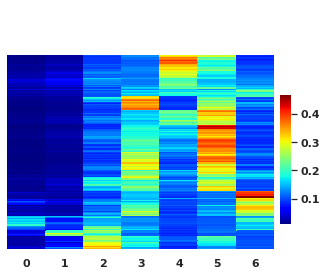

In [14]:
print(p_target[1])
fig =plt.figure(figsize=(5,4))
g=sns.clustermap(p_target[:,keys], cmap="jet", metric= 'euclidean', figsize=(5, 4),
                   yticklabels=False, xticklabels=True, col_cluster=False)
g.cax.set_position([.98, .2, .03, .45])
g.ax_row_dendrogram.set_visible(False)
#g.savefig(dataset+'_cluster_assignment.pdf', bbox_inches='tight')


# Learned K

Text(0, 0.5, 'Minibatch $K$')

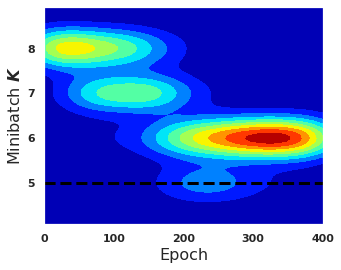

In [15]:
#https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/
fig=plt.figure(figsize=(5,4))
# learned_k =  np.load(data_path + model + "learned_K.npy")
learned_k =  np.load(data_path + "learned_K.npy")

b = np.sort(learned_k,axis=1)
count_K = (b[:,1:] != b[:,:-1]).sum(axis=1)+1

range_x = np.arange(start=0, stop=len(count_K))
plt.axhline(y= 5, color='black', label='mean', linestyle='--', lw=3)

sns.kdeplot(range_x, count_K, cmap="jet", shade=True)

plt.xlim([min(range_x), max(range_x)+2])
plt.xlabel('Epoch', fontsize=fontsize)
plt.ylabel('Minibatch $K$', fontsize=fontsize)
#fig.savefig(dataset+'_K_epoch.pdf', bbox_inches='tight')

# LogRank

In [16]:
#https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html
result = multivariate_logrank_test(empirical, nn_model, event)
result.print_summary()
print(result.test_statistic)
print(result.p_value)


t_0=-1, alpha=0.95, null_distribution=chi squared, df=6

 test_statistic      p     
        46.2677 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
46.267669354478095
2.618610653043387e-08
